En este archivo se mostraran los resúmenes de las métricas de rendimiento que cada modelo ha obtenido en los procesos anteriores. Además, se implementarán distintos "ensemble" de los modelos, para obtener resultados globales con todos los modelos entrenados. 

Primero de todo importamos las librerías que vamos a utilizar.

In [23]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

Declaramos constantes globales, como pueden ser los *métodos*, *conjuntos de datos*, *nombres de las métricas* así como *índices de las clases*.

In [24]:
METHODS = ['knn', 'svm', 'naive_bayes', 'random_forest']
SETS = [
    'normalized', 'normalized_pca_80', 'normalized_pca_95',
    'original', 'original_pca_80', 'original_pca_95',
    'standarized', 'standarized_pca_80', 'standarized_pca_95'
]
METRICS_NAMES = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1_Score', 'FNR', 'FPR', 'AUC']
TARGET_NAMES = ['0-1', '1-0', '1/2-1/2']
CLASSES = ['0', '1', '2']

Creamos los directorios necesarios para almacenar los resultados.

In [25]:
# Creación de directorios necesarios
CWD = os.getcwd()
RESULTS_PATH = os.path.join(CWD, "results")
FIGURES_PATH = os.path.join(CWD, "figures")
DATA_PATH = os.path.join(CWD, "data")
METRICS_PATH = os.path.join(CWD, "metrics")

try:
    os.mkdir(RESULTS_PATH)
    os.mkdir(FIGURES_PATH)
except FileExistsError:
    pass


## Función
Creamos una función `calcula_media_desv_tipica` para ahorrarnos repetir código en la generación de los *.csv* con los resultados.

In [26]:
def calcula_media_desv_tipica(method: str, set: str):

    # Cargamos las métricas del modelo y conjunto correspondientes
    full_path = os.path.join(METRICS_PATH, f"{method}_{set}_metrics.csv")
    metrics = pd.read_csv(full_path, index_col="fold")
    
    # Calculamos media y desv. típica de cada columna
    mean = metrics.mean().to_numpy()
    std = metrics.std().to_numpy()

    results = [f"{set}"]
    for i in range(0, mean.shape[0]):
        results.append(f"{mean[i]:.3f} $\pm$ {std[i]:.3f}")

    return results

<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
C:\Users\gonza\AppData\Local\Temp\ipykernel_15556\767665287.py:13: SyntaxWarning: invalid escape sequence '\p'
  results.append(f"{mean[i]:.3f} $\pm$ {std[i]:.3f}")


## Generación de los resultados
Utilizando la función anteriormente mencionada, así como iterando entre los distintos modelos, obtenemos los distintos resultados que se piden en el *enunciado*.

In [27]:
f1_summary_path_tex_ori = os.path.join(RESULTS_PATH, f"ori_f1_table.tex")
f1_summary_path_tex_norm = os.path.join(RESULTS_PATH, f"norm_f1_table.tex")
f1_summary_path_tex_stand = os.path.join(RESULTS_PATH, f"stand_f1_table.tex")

f1_summary_path_csv = os.path.join(RESULTS_PATH, f"f1_table.csv")

# Tabla para almacenar los f1-score de cada modelo en cada conjunto de datos
f1_summary_table = []

for method in METHODS:
    
    # Generamos la tabla con las métricas del método correspondiente
    tabla_metodo = []
    for set in SETS:
        fila = calcula_media_desv_tipica(method, set)
        tabla_metodo.append(fila)

    # Generamos un dataframe a partir de dicha tabla
    df = pd.DataFrame(tabla_metodo, columns=["Set", *METRICS_NAMES])
    
    # Guardamos los resultados de la tabla en formato latex y csv
    csv_path = os.path.join(RESULTS_PATH, f"{method}.csv")
    tex_path = os.path.join(RESULTS_PATH, f"{method}.tex")
    df.to_csv(csv_path, index=False)
    df.to_latex(tex_path, index=False, caption=f"Resultados para {method}")

    f1_values = df["F1_Score"].to_list()
    f1_summary_table.append(f1_values)

f1_summary_table_df = pd.DataFrame(f1_summary_table, columns=SETS, index=METHODS)

# Guardamos la tabla con los f1-scores en formatos latex y csv
f1_summary_table_df.to_csv(f1_summary_path_csv)

f1_summary_table_df[['normalized', 'normalized_pca_80', 'normalized_pca_95']] \
    .to_latex(f1_summary_path_tex_norm, caption="Resumen F1-Score por Método y Datasets normalizados")

f1_summary_table_df[['original', 'original_pca_80', 'original_pca_95']] \
    .to_latex(f1_summary_path_tex_ori, caption="Resumen F1-Score por Método y Dataset originales")

f1_summary_table_df[['standarized', 'standarized_pca_80', 'standarized_pca_95']] \
    .to_latex(f1_summary_path_tex_stand, caption="Resumen F1-Score por Método y Dataset estandarizados")
            

A fin de crear las gráficas, se crea un dataset con las medias de las métricas para cada método

In [28]:
plot_data = []

for method in METHODS:
    for dataset in SETS:
        full_path = os.path.join(METRICS_PATH, f"{method}_{dataset}_metrics.csv")
        
        if os.path.exists(full_path):
            metrics = pd.read_csv(full_path, index_col="fold")
            means = metrics.mean()
            
            entry = {
                'Method': method,
                'Set': dataset,
                'FP': means.get('FPR', 0), 
                'FN': means.get('FNR', 0), 
                'PR': means.get('Precision', 0),
                'RC': means.get('Sensitivity', 0),
                'ACC': means.get('Accuracy', 0),
                'Fm': means.get('F1_Score', 0)
            }
            plot_data.append(entry)

df_plot = pd.DataFrame(plot_data)

En el siguiente bloque se generan las gráficas que comparan distintas métricas de un mismo método, por ejemplo, *FN contra FP*.

In [29]:
# Función para comparar entre dos métricas de un mismo método
def plot_lines_comparison(method_name, df_method, metric1, metric2, label1, label2, title, filename):
    plt.figure(figsize=(12, 6))
    
    # Eje X: Los datasets en el orden definido en SETS
    x_values = df_method['Set']
    y1_values = df_method[metric1]
    y2_values = df_method[metric2]
    
    # Dibujamos las dos líneas
    plt.plot(x_values, y1_values, marker='o', linestyle='-', linewidth=2, label=label1, color='blue')
    plt.plot(x_values, y2_values, marker='s', linestyle='--', linewidth=2, label=label2, color='orange')
    
    plt.title(f"{title} - {method_name}", fontsize=14)
    plt.xlabel("Conjunto de Datos", fontsize=12)
    plt.ylabel("Valor Métrica", fontsize=12)
    plt.ylim(-0.05, 1.05) # Fijamos el eje Y entre 0 y 1 para ver mejor las diferencias
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # Rotamos las etiquetas del eje X para que se lean bien
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    save_path = os.path.join(FIGURES_PATH, filename)
    plt.savefig(save_path)
    plt.close()

# 3. Bucle principal
for method in METHODS:
    # Filtramos los datos solo para el método actual
    # Reindexamos por SETS para asegurar que el eje X siga el orden lógico (Norm -> Norm_PCA...)
    # y no el orden alfabético aleatorio.
    df_method = df_plot[df_plot['Method'] == method].set_index('Set').reindex(SETS).reset_index()
    
    # a) ACC contra Fm
    plot_lines_comparison(
        method, df_method, 
        'ACC', 'Fm', 
        'Accuracy', 'F1-Score', 
        'Comparativa Accuracy vs F1-Score', 
        f"ACC_vs_Fm_{method}.png"
    )
    
    # b) FN contra FP
    plot_lines_comparison(
        method, df_method, 
        'FN', 'FP', 
        'False Negative Rate', 'False Positive Rate', 
        'Comparativa FN vs FP', 
        f"FN_vs_FP_{method}.png"
    )
    
    # c) PR contra RC
    plot_lines_comparison(
        method, df_method, 
        'PR', 'RC', 
        'Precision', 'Recall', 
        'Comparativa Precision vs Recall', 
        f"PR_vs_RC_{method}.png"
    )

A continuación, se generan gráficas de comparación de una misma métrica entre los distintos métodos, para obtener una comparación global. Primero se genera una dataset con la media de las métricas por cada método.

In [30]:
def load_all_results():
    all_data = []
    
    for method in METHODS:
        for dataset in SETS:
            filename = f"{method}_{dataset}_metrics.csv"
            filepath = os.path.join(METRICS_PATH, filename)
            
            if os.path.exists(filepath):
                df = pd.read_csv(filepath)
                
                # Calculamos la media de los 5 folds para cada métrica
                mean_metrics = df.mean(numeric_only=True)

                # Eliminamos la columa 'fold' porque no es una métrica
                mean_metrics = mean_metrics.drop('fold')
                
                # Guardamos la info
                row = mean_metrics.to_dict()
                row['Method'] = method
                row['Set'] = dataset
                all_data.append(row)
            else:
                print(f"Aviso: No se encontró {filename}")
    
    return pd.DataFrame(all_data)

# Cargamos el DataFrame Maestro
df_results = load_all_results()

# Mostramos las primeras filas para verificar
print(df_results.head)

<bound method NDFrame.head of     Accuracy  Sensitivity  Specificity  Precision  F1_Score       FNR  \
0     0.4875     0.351473     0.672000   0.462723  0.399264  0.648527   
1     0.4865     0.337888     0.670979   0.324222  0.330913  0.662112   
2     0.4835     0.350960     0.669651   0.462395  0.398945  0.649040   
3     0.4953     0.343841     0.676626   0.329913  0.336731  0.656159   
4     0.4836     0.336006     0.669254   0.322346  0.329033  0.663994   
5     0.4836     0.336006     0.669254   0.322346  0.329033  0.663994   
6     0.4918     0.353799     0.675463   0.432677  0.387087  0.646201   
7     0.4962     0.351619     0.677823   0.445397  0.388737  0.648381   
8     0.4918     0.353799     0.675463   0.432677  0.387087  0.646201   
9     0.5103     0.346957     0.679348   0.337799  0.342310  0.653043   
10    0.4965     0.333370     0.666707   0.319146  0.326060  0.666630   
11    0.4965     0.336285     0.669468   0.324682  0.330377  0.663715   
12    0.5121     0.34

Se generan a continuación los gráficos comparativos de algunas métricas entre todos los métodos. Estas son comparaciones best-vs-best, es decir, se selecciona el mejor valor obtenido para cada modelo, y se realiza la comparación entre ellos.

Mejores configuraciones encontradas:


,Method,Set,F1_Score
1,naive_bayes,standarized_pca_95,0.436498
2,random_forest,standarized_pca_95,0.404479
0,knn,normalized,0.399264
3,svm,original,0.373061


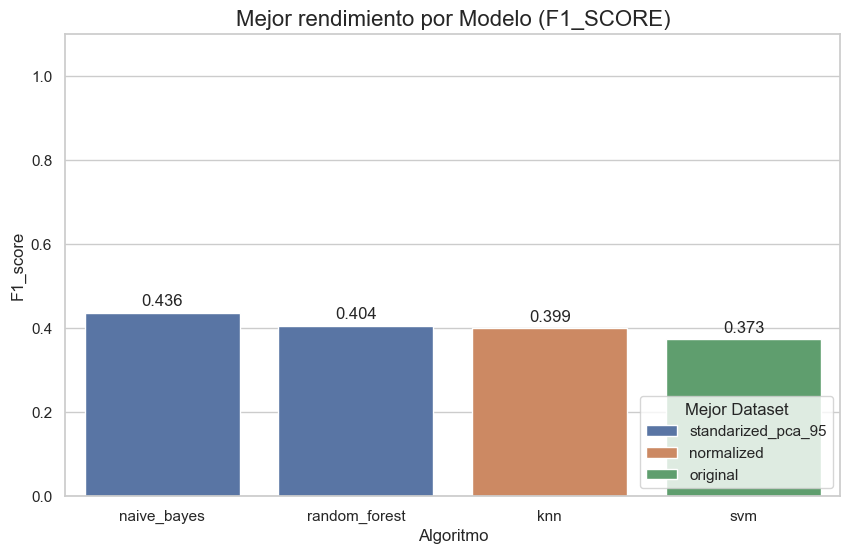

Mejores configuraciones encontradas:


,Method,Set,AUC
1,naive_bayes,standarized_pca_95,0.657247
2,random_forest,standarized_pca_95,0.631537
3,svm,normalized,0.607189
0,knn,standarized_pca_95,0.573232


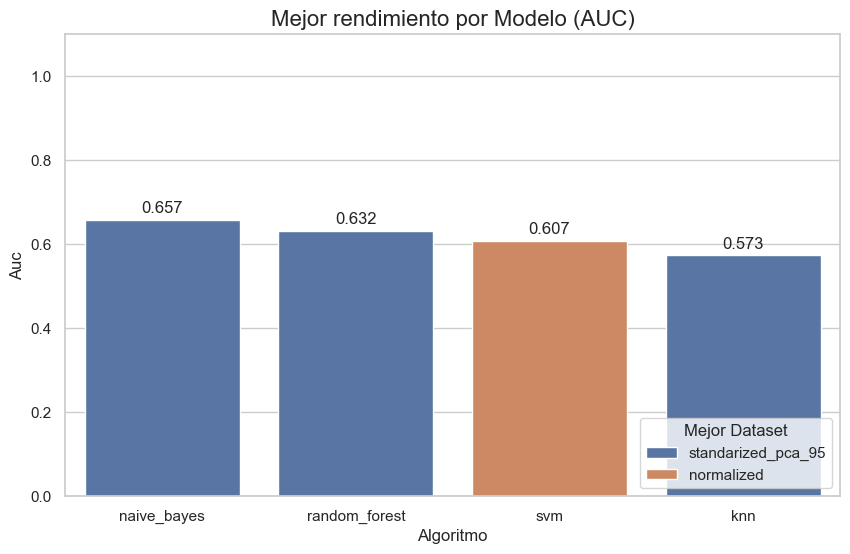

Mejores configuraciones encontradas:


,Method,Set,Specificity
1,naive_bayes,standarized_pca_95,0.693408
3,svm,standarized_pca_80,0.686820
2,random_forest,standarized_pca_95,0.686255
0,knn,standarized_pca_80,0.677823


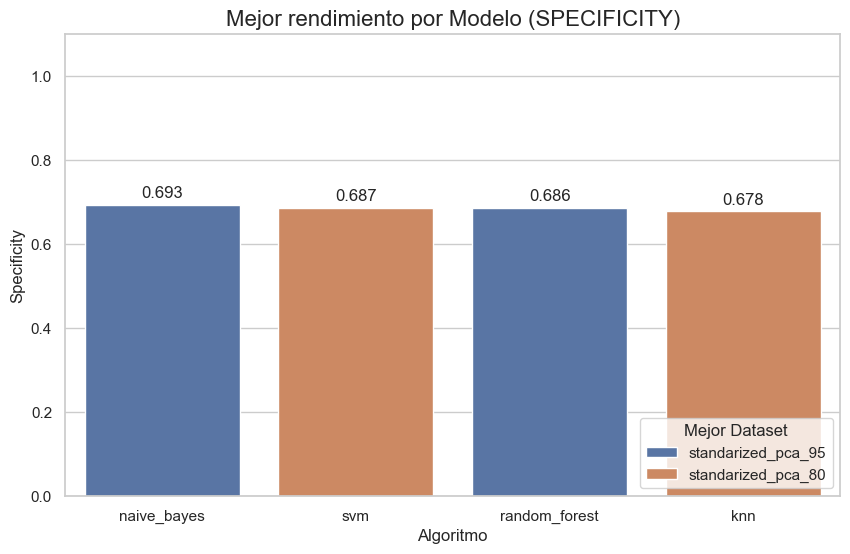

Mejores configuraciones encontradas:


,Method,Set,Sensitivity
1,naive_bayes,standarized_pca_95,0.421597
2,random_forest,standarized_pca_95,0.376565
3,svm,standarized_pca_80,0.355031
0,knn,standarized,0.353799


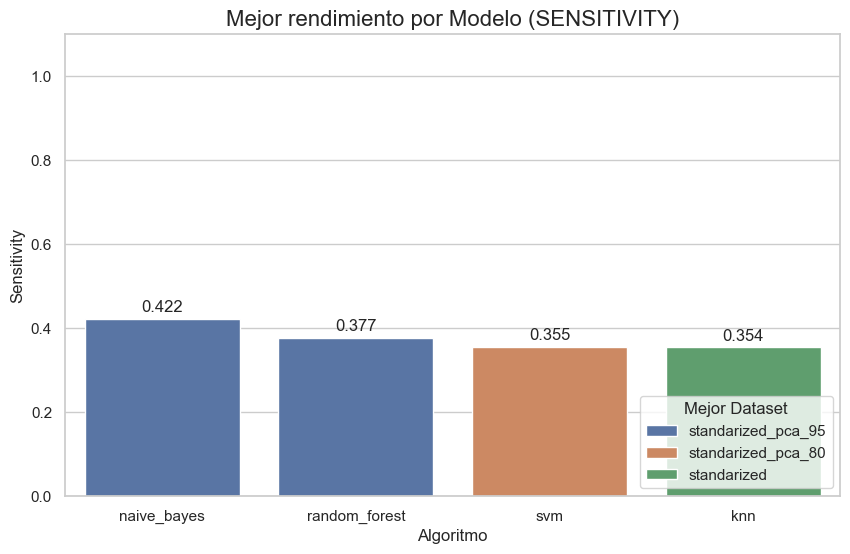

In [34]:
def plot_best_models_comparison(df, metric_col='f1'):
    """
    Busca el mejor dataset para cada modelo y los compara entre sí.
    """
    # Agrupamos por método y buscamos el índice del máximo valor en la métrica
    idx = df.groupby('Method')[metric_col].idxmax()
    best_models = df.loc[idx].reset_index(drop=True)
    
    # Ordenamos de mejor a peor para que la gráfica quede bonita
    best_models = best_models.sort_values(by=metric_col, ascending=False)

    print("Mejores configuraciones encontradas:")
    display(best_models[['Method', 'Set', metric_col]])

    # Graficamos
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    ax = sns.barplot(
        data=best_models, 
        x='Method', 
        y=metric_col, 
        hue='Set', # El color indicará qué dataset fue el mejor
        dodge=False 
    )
    
    plt.title(f"Mejor rendimiento por Modelo ({metric_col.upper()})", fontsize=16)
    plt.ylabel(metric_col.capitalize(), fontsize=12)
    plt.xlabel("Algoritmo", fontsize=12)
    plt.ylim(0, 1.1)
    plt.legend(title="Mejor Dataset", loc='lower right')

    # Etiquetas de valor
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)

    plt.savefig(os.path.join(FIGURES_PATH, f"best_models_comparison_{metric_col}.png"), bbox_inches='tight')
    plt.show()

# --- EJECUTAR ---
plot_best_models_comparison(df_results, metric_col='F1_Score')
plot_best_models_comparison(df_results, metric_col='AUC')
plot_best_models_comparison(df_results, metric_col='Specificity')
plot_best_models_comparison(df_results, metric_col='Sensitivity')

Se puede observar que los 4 métodos están bastante empatados, y mostrando valores bastante bajos. No obstante, Naive Bayes siempre se posiciona primera en todas las comparativas, demostrando un mejor desempeño en su mejor caso.

Es también destacable el 

# Ensemble
En este apartado generaremos los distintos **ensembles** que se piden: decisión por votación, media y mediana. Antes de todo, creamos una función que leerá los *csv* con las predicciones para ahorrar repetición de código.

In [ ]:
def obtener_probabilidad(model_name, fold, set):
    """
    Obtienes el dataframe de probabilidades del modelo, fold y set especificado

    Args:
        model_name (str): Nombre del modelo (e.g., 'knn').
        fold (int): Número de la partición (e.g., 1).
        set_name (str): Versión del conjunto de datos (e.g., 'norm').

    Returns:
        pd.DataFrame: DataFrame con los resultados, o None si el archivo no existe.
    """
    # Obtenemos el path del csv y lo cargamos
    file_name = f"pred_{fold}_{set}_{model_name}.csv"
    full_path = os.path.join("predictions", file_name)

    predictions_df = pd.read_csv(full_path)

    return predictions_df

In [ ]:
def generar_ensemble(strategy: str, sets: list, methods: list, classes: list):
    """
    Genera los archivos de ensemble según la estrategia dada.
    
    Args:
        strategy (str): 'votes', 'avg', o 'median'.
        sets (list): Lista de conjuntos de datos.
        methods (list): Lista de modelos.
        classes (list): Lista de nombres de clases.
    """
    folder_map = {
        'votes': 'ensemble_votes',
        'avg': 'ensemble_avg',
        'median': 'ensemble_median'
    }
    folder_name = folder_map.get(strategy)
    
    # Crear directorio si no existe
    os.makedirs(folder_name, exist_ok=True)

    print(f"--- Generando Ensembles: {strategy.upper()} ---")

    for dataset in sets:
        for fold in range(1, 6):
            prediction_dfs = []

            # Cargar predicciones de todos los modelos
            for method in methods:
                try:
                    df = obtener_probabilidad(method, fold, dataset)
                    if df is not None and not df.empty:
                        prediction_dfs.append(df)
                except Exception as e:
                    print(f"Error cargando {method} fold {fold}: {e}")

            if not prediction_dfs:
                continue

            # Agrupamos por el índice original para operar sobre las mismas filas
            df_concat = pd.concat(prediction_dfs)
            
            # DataFrame resultado
            df_result = pd.DataFrame(index=prediction_dfs[0].index, columns=classes)
            
            # Aplicar estrategia
            if strategy == 'votes':
                # Convertir probabilidades a votos (1 para la clase máxima, 0 resto)
                # Para cada modelo, obtenemos la clase predicha
                votes_df = pd.DataFrame(index=prediction_dfs[0].index)
                for i, df in enumerate(prediction_dfs):
                    votes_df[f'model_{i}'] = df[classes].idxmax(axis=1)
                
                # Contar votos
                ensemble_decision = votes_df.mode(axis=1)[0]
                
                for col in classes:
                    df_result[col] = (votes_df == col).sum(axis=1) / len(prediction_dfs)
                
                df_result['Ensemble_Decision'] = ensemble_decision

            elif strategy == 'avg':
                # Calcular la media
                df_mean = df_concat.groupby(level=0).mean()
                df_result[classes] = df_mean[classes].round(3)
                df_result['Ensemble_Decision'] = df_result[classes].idxmax(axis=1)

            elif strategy == 'median':
                # Calcular la mediana
                df_median_val = df_concat.groupby(level=0).median()
                df_result[classes] = df_median_val[classes].round(3)
                df_result['Ensemble_Decision'] = df_result[classes].idxmax(axis=1)

            # Guardar resultado
            file_name = f"{strategy}_fold{fold}_{dataset}.csv"

            # Ajuste para nombre de archivo de votación
            if strategy == 'votes':
                file_name = f"votes_fold{fold}_{dataset}.csv"
                
            full_path = os.path.join(folder_name, file_name)
            df_result.to_csv(full_path, index=True, index_label='Index')
            
    print(f"Completado {strategy}.\n")

# Ejecutar para las 3 estrategias
generar_ensemble('votes', SETS, METHODS, CLASSES)
generar_ensemble('avg', SETS, METHODS, CLASSES)
generar_ensemble('median', SETS, METHODS, CLASSES)

--- Generando Ensembles: VOTES ---
Completado votes.

--- Generando Ensembles: AVG ---
Completado avg.

--- Generando Ensembles: MEDIAN ---
Completado median.



### Métricas ensemble
A continuación, vamos a calcular el rendimiento de los ensemble realizados con cada método, para comprobar cual es la mejor técnica.

In [ ]:
from numpy import int64
from sklearn.metrics import classification_report, roc_auc_score, multilabel_confusion_matrix
from sklearn.preprocessing import LabelBinarizer

METHODS_ENSEMBLE = ['votes', 'avg', 'median']
METRICS_NAMES_ENSEMBLE = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1_Score', 'FNR', 'FPR', 'AUC']

# Tabla final
results_summary = []

for method in METHODS_ENSEMBLE:
    
    # Nombre de carpeta según el método
    folder_map = {'votes': 'ensemble_votes', 'avg': 'ensemble_avg', 'median': 'ensemble_median'}
    folder = folder_map.get(method, f"ensemble_{method}")
    
    tabla_metodo = []

    for dataset in SETS:
        fold_metrics = []

        for fold in range(1, 6):
            # Carga de csv
            path_test = os.path.join(DATA_PATH, dataset, f"test{fold}_{dataset}.csv")
            df_test = pd.read_csv(path_test)
            y_true = df_test.iloc[:, -1]    # La columna Result es la clase objetivo

            prefix = "votes" if method == "votes" else method 
            file_name = f"{prefix}_fold{fold}_{dataset}.csv"
            path_pred = os.path.join(folder, file_name)
            
            try:
                df_pred = pd.read_csv(path_pred, index_col="Index")
            except FileNotFoundError:
                print(f"Archivo no encontrado: {path_pred}")
                continue

            y_pred = df_pred['Ensemble_Decision']
            # Probabilidades para AUC
            y_proba = df_pred[CLASSES].values

            
            # Calculamos el reporte general con sklearn
            report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
            
            accuracy = report['accuracy']
            sensitivity = report['macro avg']['recall']
            precision = report['macro avg']['precision']
            f1 = report['macro avg']['f1-score']

            # Calculamos el resto de métricas con la matriz de confusión
            mcm = multilabel_confusion_matrix(y_true, y_pred)

            tn = mcm[:, 0, 0]
            tp = mcm[:, 1, 1]
            fn = mcm[:, 1, 0]
            fp = mcm[:, 0, 1]

            specificity = np.mean(tn / (tn + fp)) if np.any(tn + fp) else 0
            fnr = np.mean(fn / (fn + tp)) if np.any(fn + tp) else 0
            fpr = np.mean(fp / (fp + tn)) if np.any(fp + tn) else 0

            try:
                auc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
            except ValueError:
                auc = 0.5 

            metrics = [accuracy, sensitivity, specificity, precision, f1, fnr, fpr, auc]
            fold_metrics.append(metrics)

        # Promediar folds
        if fold_metrics:
            df_folds = pd.DataFrame(fold_metrics, columns=METRICS_NAMES_ENSEMBLE)
            mean = df_folds.mean().values
            std = df_folds.std().values

            # Formatear para tabla (Media +- Desv)
            fila = [dataset]
            for m, s in zip(mean, std):
                fila.append(f"{m:.3f} $\\pm$ {s:.3f}")
            tabla_metodo.append(fila)

    # Guardar resultados de este método
    df_res = pd.DataFrame(tabla_metodo, columns=["Set"] + METRICS_NAMES_ENSEMBLE)
    
    out_csv = os.path.join(RESULTS_PATH, f"ensemble_{method}_metrics.csv")
    out_tex = os.path.join(RESULTS_PATH, f"ensemble_{method}_metrics.tex")
    
    df_res.to_csv(out_csv, index=False)
    df_res.to_latex(out_tex, index=False, caption=f"Resultados Ensemble: {method}")
    
    print(f"Resultados guardados para {method}")

Resultados guardados para votes
Resultados guardados para avg
Resultados guardados para median
